In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/GAN/"
%cd gdrive/My\ Drive/GAN/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/GAN


#1. Import Libraries

In [0]:
#Utils
import os
import numpy as np
from tqdm import tqdm_notebook, tqdm
from skimage.io import imshow
from matplotlib import pyplot as plt
import random
import math
from datetime import datetime
import h5py

#Keras
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


#Constants
latent_input_dimension = 10
input_shape = (128, 128, 1)

## 2. Loading Data

In [21]:
image_file = './Data/face_images.h5py'
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('images')
images = np.array(n1)
print(images.shape)
hfile.close()

(100000, 128, 128)


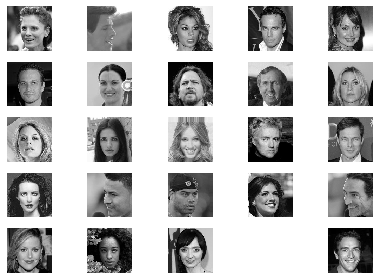


Shape of image: (100000, 128, 128, 1)


In [22]:
images = images.astype(np.float32)/255.0

num_samples = 25
sqrt = int(math.sqrt(num_samples))

for n in range(1, num_samples+1):
	plt.subplot(sqrt, sqrt, n)
	plt.axis('off')
	imshow(images[n])
plt.show();

images = np.expand_dims(images, -1)
print("\nShape of image: {}".format(images.shape))

### Writing Data Loader Functions

In [0]:
def generate_real_train_batch(images, batch_size):
  rand_vals = [random.randrange(0, images.shape[0]) for n in range(batch_size)]
  return images[rand_vals], np.ones((batch_size, 1))
  
def generate_latent_space_points(batch_size):
  latent_space = np.random.randn(latent_input_dimension * batch_size)
  latent_space = latent_space.reshape(batch_size, latent_input_dimension)
  return latent_space

def generate_fake_train_batch(generator, batch_size):
  latent_input = generate_latent_space_points(batch_size)
  fake_samples = generator.predict(latent_input)
  return fake_samples, np.zeros((batch_size, 1))

## 3. Neural Modelling

### 3.1 Building the generator

In [26]:
generator = Sequential()

generator.add(Dense(128*128*128, input_dim=latent_input_dimension))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 128, 128)))
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid'))
print(generator.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2097152)           23068672  
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 2097152)           0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 256, 256, 128)     262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 512, 512, 128)     262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 512, 512, 128)    

### 3.2 Building the Discriminator

In [27]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 1), kernel_initializer='he_normal'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)          

### 3.3 compiling the models

In [0]:
learning_rate = 0.0002
beta = 0.5
batch_size = 64
num_display_samples = 25
half_batch = int(batch_size/2)
epochs = 200
steps_per_epoch = int(images.shape[0]/batch_size)


adam = Adam(lr=learning_rate, beta_1=beta)
generator.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=adam)
discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=adam)

### 3.4 Training Discriminator

In [29]:
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam)
print(gan.summary())

ValueError: ignored

In [0]:
def plot_images(images, num_samples):
  
  sqrt = int(math.sqrt(num_samples))

  for n in range(1, num_samples+1):
    ix = random.randint(1,999)
    plt.subplot(sqrt, sqrt, n)
    plt.axis('off')
    imshow(images[ix][:,:, 0])
  
  plt.show();

def saveModels(epoch):
    generator.save('./Models/dcgan_fashion_generator_epoch_%d.h5' % epoch)
    discriminator.save('./Models/dcgan_fashion_discriminator_epoch_%d.h5' % epoch)

In [0]:
print('Total Training Progress:\n')
prev_g_loss = 999
for epoch in tqdm_notebook(range(1, epochs+1), total = epochs):
  start_time = datetime.now()
  print("\nEPOCH {:0>3d}:".format(epoch))
  for step in tqdm_notebook(range(steps_per_epoch), total = steps_per_epoch):
    real_images, real_labels = generate_real_train_batch(images, half_batch)
    fake_images, fake_labels = generate_fake_train_batch(generator, half_batch)

    discriminator_images, discriminator_labels = np.vstack((real_images, fake_images)), np.vstack((real_labels, fake_labels))

    disc_loss, _ =  discriminator.train_on_batch(discriminator_images, discriminator_labels)

    gan_images = generate_latent_space_points(batch_size)
    gan_labels = np.ones((batch_size, 1))

    gan_loss = gan.train_on_batch(gan_images, gan_labels)
  
  generated_images,_ = generate_fake_train_batch(generator,1000)
  plot_images(generated_images, num_display_samples)

  epoch_time = datetime.now() - start_time
  text_template = "Time: {:.5f} | D Loss: {:.5f} | G Loss: {:.5f}"
  print(text_template.format((epoch_time.total_seconds()), disc_loss, gan_loss))

  if (gan_loss < prev_g_loss):
    prev_g_loss = gan_loss
    saveModels(epoch)
    print("Gan loss improved from {:.5f} to {:.5f}. Saving the model.".format(prev_g_loss, gan_loss)) 
  